# Capstone Project: Twitter Scraping Tool

## Importing Libraries

In [1]:
# Misc
import gc
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import tkinter as tk

# Data Scraping
import multiprocessing
from multiprocessing import Manager
from multiprocessing.pool import ThreadPool as Pool
import snscrape.modules.twitter as snstwitter
import pandas as pd

# Machine Learning
from kmodes.kmodes import KModes

# NLP
import pytextrank
import spacy
import re
import emoji
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

## Scraping Data

### Scraping Initial Tweets

In [2]:
def scraper(n):
    total_tweets = []
    term = 'esports OR gaming OR twitch OR streamer OR fitness OR sports OR gym OR bodybuilding OR fashion OR beauty OR makeup OR outfit OR technology OR tech OR AI OR gadgets OR entertainment OR movies OR actors'
    query = ' '.join([term, f'since:{get_date(n)}', f'until:{get_date(n+1)}', 'lang:en', '(filter:safe OR -filter:safe)', '-kpop', 'min_faves:750'])
    print(f"\nQuerying {get_date(n)} to {get_date(n+1)} on process thread no. {n}")
    for i, tweet in enumerate(snstwitter.TwitterSearchScraper(query).get_items()):
        tweet_details = {
            'id':tweet.id,
            'date':tweet.date,
            'username':tweet.user.username,
            'text':tweet.rawContent,
            'like_count':tweet.likeCount,
            'reply_count':tweet.replyCount,
            'retweet_count':tweet.retweetCount,
            'quote_count':tweet.quoteCount,
            'mentioned':[i.username for i in tweet.mentionedUsers] if tweet.mentionedUsers else tweet.mentionedUsers,
            'hashtags':tweet.hashtags,
            'coordinates':tweet.coordinates,
            'url':tweet.url
        }
        total_tweets.append(tweet_details)
    return pd.DataFrame(total_tweets)

def set_date(start, end):
    return pd.date_range(start, end)

def get_date(date):
    return date_range[date].strftime('%Y-%m-%d')

In [3]:
print("Number of CPU Threads Available: ", multiprocessing.cpu_count())

if multiprocessing.cpu_count() > 2:
    cpu_no = multiprocessing.cpu_count()-2  
else:
    cpu_no = multiprocessing.cpu_count()
    print("WARNING: Your system might get slow or unresponsive while scraping. \nPlease do not interact with the system while Data Scraping is in progress")  
print(f"Allocating {cpu_no} CPU Threads for Scraping")

Number of CPU Threads Available:  12
Allocating 10 CPU Threads for Scraping


In [4]:
with Manager() as manager:
    tweets_df = pd.DataFrame()
    
    # mm/dd/yyyy
    start = '1/1/2023'
    end = '4/1/2023'
    date_range = set_date(start, end)

    sum_of_tweets = 0
    date_left = len(date_range)
    pool = Pool(cpu_no)
    for result in pool.imap_unordered(scraper, range(0, len(date_range)-1)):
        tweets_df = tweets_df.append(result, ignore_index=True)
        sum_of_tweets = sum_of_tweets + result.shape[0]
        date_left -= 1
        print(f"\n# of tweets extracted:{sum_of_tweets} | No. of process threads remaining:{date_left}")
    
    tweets_df = tweets_df.sort_values(by='date', ascending=True)
    tweets_df.to_csv(f"tweets_again.csv", index=False)


Querying 2023-01-01 to 2023-01-02 on process thread no. 0
Querying 2023-01-02 to 2023-01-03 on process thread no. 1

Querying 2023-01-03 to 2023-01-04 on process thread no. 2


Querying 2023-01-04 to 2023-01-05 on process thread no. 3

Querying 2023-01-05 to 2023-01-06 on process thread no. 4

Querying 2023-01-06 to 2023-01-07 on process thread no. 5

Querying 2023-01-07 to 2023-01-08 on process thread no. 6

Querying 2023-01-08 to 2023-01-09 on process thread no. 7

Querying 2023-01-09 to 2023-01-10 on process thread no. 8

Querying 2023-01-10 to 2023-01-11 on process thread no. 9

Querying 2023-01-11 to 2023-01-12 on process thread no. 10
# of tweets extracted:168 | No. of process threads remaining:90


Querying 2023-01-12 to 2023-01-13 on process thread no. 11
# of tweets extracted:339 | No. of process threads remaining:89


Querying 2023-01-13 to 2023-01-14 on process thread no. 12

# of tweets extracted:512 | No. of process threads remaining:88

Querying 2023-01-14 to 2023-01-15 

### Reading Data

In [5]:
twitter_df = pd.read_csv('tweets_again.csv')

In [6]:
twitter_df.drop_duplicates('text', inplace=True, keep='first', ignore_index=True)

In [7]:
twitter_df.shape

(23722, 12)

In [8]:
twitter_df

,id,date,username,text,like_count,reply_count,retweet_count,quote_count,mentioned,hashtags,coordinates,url
0,1609339408347697153,2023-01-01 00:03:09+00:00,JackManifoldTV,I am currently in 2023. Elon Musk has ruined i...,16482,168,243,4,NaN,NaN,NaN,https://twitter.com/JackManifoldTV/status/1609...
1,1609340683722326017,2023-01-01 00:08:13+00:00,queeniemalx,“iKON who left YG Entertainment signed an excl...,12120,25,3570,974,['YG_iKONIC'],"['iKON', '아이콘']",NaN,https://twitter.com/queeniemalx/status/1609340...
2,1609341931779395584,2023-01-01 00:13:11+00:00,yunbinic,"""All members of the group iKON who left YG Ent...",7564,1,2353,387,NaN,NaN,NaN,https://twitter.com/yunbinic/status/1609341931...
3,1609342311988711424,2023-01-01 00:14:41+00:00,mollyhannahm,this year has been pretty cool. graduated coll...,1666,23,7,0,NaN,NaN,NaN,https://twitter.com/mollyhannahm/status/160934...
4,1609342584320655364,2023-01-01 00:15:46+00:00,SydneyBattle,one of my favorite pics from this year is when...,2616,13,10,0,NaN,NaN,NaN,https://twitter.com/SydneyBattle/status/160934...
...,...,...,...,...,...,...,...,...,...,...,...,...
23717,1641951062780424192,2023-03-31 23:50:13+00:00,SportsCenter,Lil Wayne and Flau'jae on a track 👀🔥 https://t...,1187,21,145,18,NaN,NaN,NaN,https://twitter.com/SportsCenter/status/164195...
23718,1641951659277287425,2023-03-31 23:52:36+00:00,Josepho68539155,Romantic series on Netflix wit this beauty or ...,4274,103,297,7,NaN,NaN,NaN,https://twitter.com/Josepho68539155/status/164...
23719,1641951948487393281,2023-03-31 23:53:45+00:00,nmixxpics_,"🫧 Haewon also changed her profile to ""JYP Lead...",5879,0,1122,417,NaN,NaN,NaN,https://twitter.com/nmixxpics_/status/16419519...
23720,1641952177735467008,2023-03-31 23:54:39+00:00,GenWaifus,Your doctor visits you at home to make you fee...,4066,133,251,6,NaN,"['Stablediffusion', 'AIart', 'AI', 'AIイラスト']",NaN,https://twitter.com/GenWaifus/status/164195217...


In [9]:
usernames = twitter_df['username'].unique()

len(twitter_df['username'].unique())

13012

### Scraping Users

In [10]:
import snscrape.modules.twitter as snstwitter

usernames_list=[]
for username in tqdm(usernames):
    item = snstwitter.TwitterUserScraper(username)._get_entity()
    if item == None:
        continue
    username_details = {
        'username':item.username,
        'user_id':item.id,
        'display_name':item.displayname,
        'followers_count':item.followersCount,
        'following_count':item.friendsCount,
        'tweets_count':item.statusesCount,
        'verified':item.verified
    }
    usernames_list.append(username_details)

100%|██████████| 13012/13012 [2:34:48<00:00,  1.40it/s]  


In [11]:
users_df = pd.DataFrame(usernames_list)

In [12]:
# Getting only users that exists in both dataframes
twitter_df = twitter_df[twitter_df['username'].isin(users_df['username'])]

users_df = users_df[users_df['username'].isin(twitter_df['username'])]

In [13]:
twitter_df.reset_index(inplace=True,drop=True)

users_df.reset_index(inplace=True,drop=True)

In [14]:
twitter_df.to_csv('niche_tweets.csv', index=False)

users_df.to_csv('total_users.csv', index=False)

### Scraping More Tweets

In [15]:
twitter_df = pd.read_csv('niche_tweets.csv')
users_df = pd.read_csv('total_users.csv')

In [16]:
def scraper(n):
    total_tweets = []
    user = get_user(n)
    query = f'esports OR gaming OR twitch OR streamer OR fitness OR sports OR gym OR bodybuilding OR fashion OR beauty OR makeup OR outfit OR technology OR tech OR AI OR gadgets OR entertainment OR movies OR actors from:{user} (filter:safe OR -filter:safe)'
    for i, tweet in enumerate(snstwitter.TwitterSearchScraper(query).get_items()):
        if i == 20:
            break
        elif tweet.lang == 'en':
            tweet_details = {
                'id':tweet.id,
                'date':tweet.date,
                'username':tweet.user.username,
                'text':tweet.rawContent,
                'like_count':tweet.likeCount,
                'reply_count':tweet.replyCount,
                'retweet_count':tweet.retweetCount,
                'quote_count':tweet.quoteCount,
                'mentioned':[i.username for i in tweet.mentionedUsers] if tweet.mentionedUsers else tweet.mentionedUsers,
                'hashtags':tweet.hashtags,
                'coordinates':tweet.coordinates,
                'url':tweet.url
            }
            total_tweets.append(tweet_details)
        else:
            continue
    return pd.DataFrame(total_tweets)

def get_user(user):
    return total_users[user]

In [17]:
print("Number of CPU Threads Available: ", multiprocessing.cpu_count())

if multiprocessing.cpu_count() > 2:
    cpu_no = multiprocessing.cpu_count()-2  
else:
    cpu_no = multiprocessing.cpu_count()
    print("WARNING: Your system might get slow or unresponsive while scraping. \nPlease do not interact with the system while Data Scraping is in progress")  
print(f"Allocating {cpu_no} CPU Threads for Scraping")

Number of CPU Threads Available:  12
Allocating 10 CPU Threads for Scraping


In [18]:
tweets_df2 = pd.DataFrame()
with Manager() as manager:
    total_users = users_df['username'].unique()
    
    pool = Pool(cpu_no)
    for result in tqdm(pool.imap_unordered(scraper, range(0, len(total_users)-1))):
        tweets_df2 = tweets_df2.append(result, ignore_index=True)
    
    tweets_df2 = tweets_df2.sort_values(by='date', ascending=True)
    tweets_df2.to_csv("extra_tweets.csv", index=False)

4799it [23:34,  4.45it/s]Stopping after 20 empty pages
13011it [1:02:26,  3.47it/s]


In [19]:
final_df = pd.concat([twitter_df, tweets_df2])

final_df = final_df.sample(frac=1)

final_df.drop_duplicates('text', inplace=True, keep='first')

final_df = final_df[final_df['username'].isin(users_df['username'])]

final_df.reset_index(inplace=True, drop=True)

final_df.to_csv('final_tweets.csv', index=False)

## NLP

In [20]:
twitter_df = pd.read_csv('final_tweets.csv')
users_df = pd.read_csv('total_users.csv')

In [21]:
# Cleaning Pipeline
df_grouped = twitter_df.groupby(['username'])['text'].apply(lambda x: ' '.join(x)).reset_index()
df_grouped = df_grouped.drop_duplicates()

df_grouped["text"] = df_grouped['text'].apply(lambda x: re.sub("@[A-Za-z0-9_]+","", x)) # Remove all mentions
df_grouped["text"] = df_grouped['text'].apply(lambda x: re.sub("#[A-Za-z0-9_]+","", x)) # Remove all hashtags
df_grouped["text"] = df_grouped['text'].apply(lambda x: re.sub(r"http\S+", "", x)) # Remove all http links
df_grouped["text"] = df_grouped['text'].apply(lambda x: re.sub(r"www.\S+", "", x)) # Remove all www links
df_grouped['text'] = df_grouped['text'].apply(lambda x: emoji.replace_emoji(x, '')) # Remove emojis
df_grouped["text"] = df_grouped['text'].apply(lambda x: re.sub("[^A-Za-z0-9_]+"," ", x)) 
df_grouped["text"] = df_grouped['text'].apply(lambda x: re.sub(r'[0-9]'," ", x)) # remove numbers
df_grouped["text"] = df_grouped['text'].apply(lambda x: re.sub(r'\b\w\b'," ", x)) # remove single letters

In [22]:
# Ranking words using pytextrank
nlp = spacy.load("en_core_web_sm") # load a spaCy model, depending on language, scale, etc.

for item in ['amp', 'thank', 'people', 'love', 'time', 'game', 'music']:
    nlp.Defaults.stop_words.add(item)

nlp.add_pipe("textrank") # add PyTextRank to the spaCy pipeline

doc_list = [nlp(df_grouped['text'][i]) for i in range(len(df_grouped))]

# Word Tokenization
candidate_pos = ['NOUN', 'VERB']

total_sentences = []
for i in doc_list:
    sentences = []
    for sent in i.sents:
        sentences.extend([token for token in sent if (token.pos_ in candidate_pos) & (token.is_stop == False) & (token.is_alpha == True)])
    total_sentences.append(sentences)

In [23]:
# Getting the niche for each users
total_niche = [[tup[0] for tup in Counter([str(word).lower() for word in sentence]).most_common(5)] for sentence in total_sentences]

niche_df = pd.DataFrame(total_niche, columns=['niche1', 'niche2', 'niche3', 'niche4', 'niche5'])

final_df = pd.concat([users_df, niche_df], axis=1)

In [93]:
final_df.dropna(subset=['niche1', 'niche2', 'niche3', 'niche4', 'niche5'], axis=0, inplace=True)

In [25]:
final_df

,username,user_id,display_name,followers_count,following_count,tweets_count,verified,niche1,niche2,niche3,niche4,niche5
0,JackManifoldTV,731186310552158208,Jack Manifold,1966702,1048,5311,True,outfit,don,use,artwork,stuff
1,queeniemalx,1094045263210065925,m.,6275,115,41593,False,came,gym,selfie,home,outfit
2,yunbinic,1102032583389458432,제란,6232,194,29937,False,movies,actors,things,makeup,hate
3,mollyhannahm,794993670,Molly Morrison,95585,1506,15505,True,beauty,sports,tech,stuff,pull
4,SydneyBattle,518056749,Sydney Battle,77112,691,14204,False,fashion,today,movies,wore,watched
...,...,...,...,...,...,...,...,...,...,...,...,...
13007,TheAKGuy,3396155981,Brandon Herrera,224136,198,1925,True,movies,stories,enjoy,tech,think
13008,brickroad7,1344993061588361216,renji,3010,615,6585,False,shizun,eye,makeup,tutorials,rage
13009,xnotxreal,1474525549800263682,i dont exist ⋆｡°✩,932,355,1121,False,twitch,esports,cc,streaming,amaze
13010,AstroShubh,1471218570298335237,Shubham (Astrologer)🌙,1841,268,1611,False,NaN,NaN,NaN,NaN,NaN


In [47]:
final_df['niche1'].value_counts()[:15]

movies           1743
sports           1096
gym               903
beauty            865
outfit            800
tech              788
fashion           772
makeup            439
twitch            322
technology        316
actors            316
gaming            292
entertainment     142
art               122
women             116
Name: niche1, dtype: int64

In [94]:
final_df[['niche1','niche2','niche3','niche4','niche5']] = final_df[['niche1','niche2','niche3','niche4','niche5']].replace({'tech': 'technology'})

In [96]:
final_df = final_df.drop(final_df[final_df['niche1'] == 'movies'].sample(frac=0.82).index)
final_df = final_df.drop(final_df[final_df['niche1'] == 'sports'].sample(frac=0.72).index)
final_df = final_df.drop(final_df[final_df['niche1'] == 'technology'].sample(frac=0.72).index)
final_df = final_df.drop(final_df[final_df['niche1'] == 'gym'].sample(frac=0.66).index)
final_df = final_df.drop(final_df[final_df['niche1'] == 'beauty'].sample(frac=0.65).index)
final_df = final_df.drop(final_df[final_df['niche1'] == 'outfit'].sample(frac=0.62).index)
final_df = final_df.drop(final_df[final_df['niche1'] == 'fashion'].sample(frac=0.61).index)
final_df = final_df.drop(final_df[final_df['niche1'] == 'makeup'].sample(frac=0.31).index)

final_df = final_df.drop(final_df[final_df['niche2'] == 'movies'].sample(frac=0.26).index)
final_df = final_df.drop(final_df[final_df['niche2'] == 'technology'].sample(frac=0.1).index)

final_df = final_df.drop(final_df[final_df['niche3'] == 'movies'].sample(frac=0.11).index)
final_df = final_df.drop(final_df[final_df['niche3'] == 'technology'].sample(frac=0.10).index)

In [100]:
final_df['niche1'].value_counts()[:15]

twitch           321
movies           311
sports           305
technology       301
beauty           300
makeup           297
gym              297
outfit           296
actors           292
fashion          291
gaming           278
entertainment    139
art              119
women            115
fitness          109
Name: niche1, dtype: int64

In [24]:
final_df.to_csv('final_users.csv', index=False)

## Machine Learning

In [2]:
final_df = pd.read_csv('final_users.csv')

In [3]:
final_df

,username,user_id,display_name,followers_count,following_count,tweets_count,verified,niche1,niche2,niche3,niche4,niche5
0,JackManifoldTV,731186310552158208,Jack Manifold,1966702,1048,5311,True,outfit,don,use,artwork,stuff
1,queeniemalx,1094045263210065925,m.,6275,115,41593,False,came,gym,selfie,home,outfit
2,yunbinic,1102032583389458432,제란,6232,194,29937,False,movies,actors,things,makeup,hate
3,mollyhannahm,794993670,Molly Morrison,95585,1506,15505,True,beauty,sports,tech,stuff,pull
4,SydneyBattle,518056749,Sydney Battle,77112,691,14204,False,fashion,today,movies,wore,watched
...,...,...,...,...,...,...,...,...,...,...,...,...
13007,TheAKGuy,3396155981,Brandon Herrera,224136,198,1925,True,movies,stories,enjoy,tech,think
13008,brickroad7,1344993061588361216,renji,3010,615,6585,False,shizun,eye,makeup,tutorials,rage
13009,xnotxreal,1474525549800263682,i dont exist ⋆｡°✩,932,355,1121,False,twitch,esports,cc,streaming,amaze
13010,AstroShubh,1471218570298335237,Shubham (Astrologer)🌙,1841,268,1611,False,NaN,NaN,NaN,NaN,NaN


### KModes

In [4]:
train_set = {
    'niche_1': final_df['niche1'],
    'niche_2': final_df['niche2'],
    'niche_3': final_df['niche3']}

train_set = pd.DataFrame(data = train_set)
train_set = train_set.fillna(value="fashion")

In [25]:
# Elbow curve to find optimal K
cost = []
K = range(1,16)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "Cao")
    kmode.fit_predict(train_set)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

KeyboardInterrupt: 

In [5]:
kmode = KModes(n_clusters=200, init = "Cao", n_init = 5, verbose=1)
clusters = kmode.fit_predict(train_set)
clusters

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1579, cost: 23257.0
Run 1, iteration: 2/100, moves: 48, cost: 23257.0


array([31,  6,  7, ..., 45,  0,  0], dtype=uint16)

In [ ]:
final_df.drop('Cluster', axis=1, inplace=True)

In [6]:
final_df.insert(0, "Cluster", clusters, True)

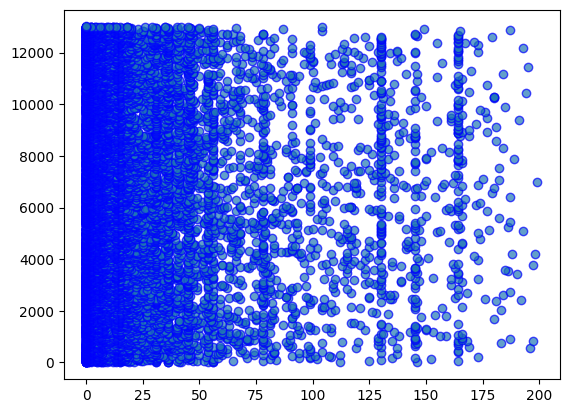

[['movies' 'fashion' 'fashion']
 ['sports' 'beauty' 'movies']
 ['gym' 'movies' 'beauty']
 ['movies' 'beauty' 'outfit']
 ['movies' 'outfit' 'beauty']
 ['movies' 'sports' 'gym']
 ['movies' 'gym' 'sports']
 ['movies' 'actors' 'tech']
 ['movies' 'tech' 'think']
 ['movies' 'makeup' 'actors']
 ['movies' 'think' 'makeup']
 ['sports' 'outfit' 'fashion']
 ['movies' 'entertainment' 'know']
 ['beauty' 'movies' 'fashion']
 ['sports' 'fashion' 'beauty']
 ['tech' 'know' 'technology']
 ['sports' 'movies' 'gym']
 ['tech' 'technology' 'art']
 ['movies' 'twitch' 'watch']
 ['movies' 'gaming' 'work']
 ['movies' 'going' 'entertainment']
 ['gym' 'beauty' 'fashion']
 ['movies' 'art' 'gaming']
 ['movies' 'watch' 'want']
 ['movies' 'look' 'need']
 ['movies' 'movie' 'going']
 ['tech' 'women' 'things']
 ['movies' 'work' 'got']
 ['movies' 'want' 'twitch']
 ['movies' 'day' 'thing']
 ['movies' 'join' 'today']
 ['outfit' 'today' 'years']
 ['movies' 'year' 'movie']
 ['tech' 'got' 'lol']
 ['movies' 'horror' 'day']
 ['

In [7]:
plt.scatter(final_df['Cluster'], final_df.index, cmap='rainbow', alpha=0.7, edgecolors='b')
plt.show()

print(kmode.cluster_centroids_)

In [8]:
x_test = {
    'niche_1': 'beauty',
    'niche_2': 'outfit',
    'niche_3': 'makeup'}
    
x_test = pd.DataFrame(data = x_test, index = [0])

kmode.predict(x_test)
print(kmode.predict(x_test))
print(kmode.cluster_centroids_[int(kmode.predict(x_test))])

[130]
['beauty' 'outfit' 'movies']


In [9]:
def predict(cluster):
    print(final_df[final_df['Cluster']==cluster].sort_values('followers_count', ascending=False)['username'])

In [10]:
predict(int(kmode.predict(x_test)))

7637             ManCity
10570    introvertsmemes
5381               Myth_
3495          KekePalmer
95              catturd2
              ...       
3681             ekp0717
9042           AyalTusia
9161        pinkdemonica
4239            BasedOwl
11814     LycorisBanashi
Name: username, Length: 94, dtype: object


In [11]:
final_df[final_df['username']=='juniorbachchan']

,Cluster,username,user_id,display_name,followers_count,following_count,tweets_count,verified,niche1,niche2,niche3,niche4,niche5


In [12]:
final_df.to_csv('users.csv', index=False)

#### Saving Model

In [127]:
with open('kmode.pickle', 'wb') as f:
    pickle.dump(kmode, f)

In [128]:
with open('kmode.pickle', 'rb') as f:
    kmode = pickle.load(f)